# Gradient-Boosting Classifiers

**Dataset:** UCI / Kaggle Bank Marketing (`bank-additional-full.csv`). ~41,000 rows, mixed types.

This notebook covers:

- Section 1: dataset, EDA, preprocessing (categorical, numerical, boolean)
- Section 2: sklearn GradientBoostingClassifier (train, tune, feature importance)
- Section 3: XGBoost (train, tune, feature importance + Optuna Bayesian tuning example)
- Section 4: LightGBM (train, tune, feature importance)
- Section 5: CatBoost (train, tune, feature importance)

**Notes:**
- Download `bank-additional-full.csv` from UCI (https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) and place it next to this notebook.
- Hyperparameter Tuning may take time depending on your machine.


**Installation Note:**

If you haven't installed the packages like xgboost, catboost, and lightGBM, use the following command to install them all in your virtual environment.

```shell
pip install xgboost catboost lightgbm
```

## Section 1 — Load data, EDA and preprocessing

We use the Bank Marketing dataset (campaign results of a Portuguese bank). Target: `y` (yes/no) — converted to binary. The dataset contains numeric, categorical and binary features.


In [1]:
# Load libraries and dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "./bank-additional-full.csv"  # place the file next to this notebook
df = pd.read_csv(DATA_PATH, sep=';')
print("Shape:", df.shape)
df.head()

Shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


object     11
int64       5
float64     5
Name: count, dtype: int64

Target distribution:
y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64

Sample missing values per column:
age          0
job          0
marital      0
education    0
default      0
dtype: int64

Categorical cols (11): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
Numeric cols (10): ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


<Figure size 1000x400 with 0 Axes>

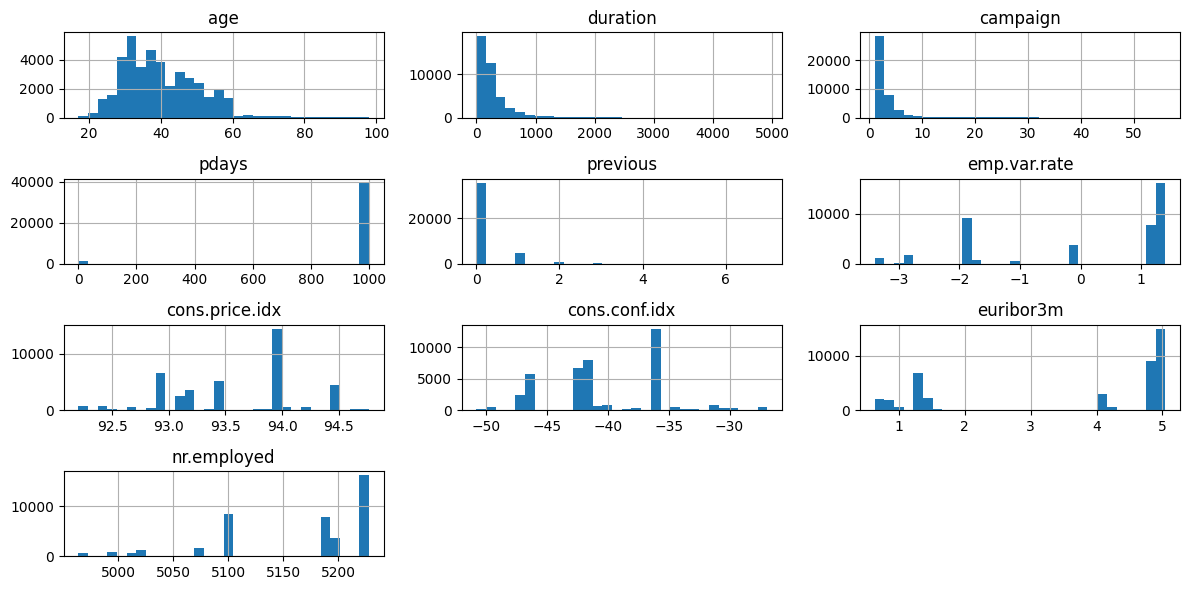

In [2]:
# Quick EDA
print(df.dtypes.value_counts())
print("\nTarget distribution:")
print(df['y'].value_counts(normalize=True))
print("\nSample missing values per column:")
print(df.isna().sum().sort_values(ascending=False).head())

# Identify types
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# In this dataset some "categorical" may be encoded as object; boolean-like cols are within object too.
print(f"\nCategorical cols ({len(cat_cols)}): {cat_cols}")
print(f"Numeric cols ({len(num_cols)}): {num_cols}")

# Convert target to 0/1
df['target'] = (df['y'] == 'yes').astype(int)
df.drop(columns=['y'], inplace=True)

# Basic numeric histograms
plt.figure(figsize=(10,4))
df[num_cols].hist(bins=30, figsize=(12,6))
plt.tight_layout()
plt.show()

### Preprocessing plan

- **Categorical**: One-hot encoding for sklearn GB; for other methods we will use Ordinal/Label encoding or let libraries handle categoricals (CatBoost accepts categorical features natively).
- **Numeric**: median imputation (though this dataset has no missing numeric values) and optional scaling for sklearn GB.
- **Train/test split**: stratified split on `target`.


In [3]:
# Train/test split and create preprocessing pipelines
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

TARGET = 'target'
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

# recompute types on train
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# preprocessing for sklearn GB (one-hot + scaling numeric)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor_sklearn = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# preprocessing for other models (ordinal encode categoricals, scale not required)
ordinal_transformer = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
])

# For CatBoost we'll pass raw data and list of categorical column names (it handles encoding)
print("Numeric cols:", len(num_cols), "Categorical cols:", len(cat_cols))

print("Numerical columns: ", num_cols)
print("Categorical columns: ", cat_cols)

Train: (32950, 20) Test: (8238, 20)
Numeric cols: 10 Categorical cols: 10
Numerical columns:  ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical columns:  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


## Section 2 — sklearn `GradientBoostingClassifier`

Gradient boosting builds an additive model of weak learners (trees). At iteration $m$ the model is:

$$F_m(x) = F_{m-1}(x) + \alpha h_m(x)$$

where $\alpha$ is the learning rate and $h_m$ is the new tree fit to the negative gradient.

**Documentation:** 

- [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

**Main hyperparameters:** `n_estimators`, `learning_rate`, `max_depth`, `subsample`, `max_features`, `min_samples_leaf`.


In [4]:
# Train a baseline sklearn GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import make_pipeline

gb_pipe = make_pipeline(preprocessor_sklearn, GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
))
gb_pipe.fit(X_train, y_train)
proba_gb = gb_pipe.predict_proba(X_test)[:,1]
print(f"Sklearn GB Test AUC: {roc_auc_score(y_test, proba_gb):.4f}")

Sklearn GB Test AUC: 0.9534


### Hyperparameter tuning (RandomizedSearchCV)

We use `RandomizedSearchCV` over reasonable ranges. 


In [5]:
# RandomizedSearchCV for sklearn GB
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

param_distributions = {
    'gradientboostingclassifier__n_estimators': randint(100, 500),
    'gradientboostingclassifier__learning_rate': uniform(0.01, 0.2),
    'gradientboostingclassifier__max_depth': randint(2, 6),
    'gradientboostingclassifier__subsample': uniform(0.6, 0.4)
}

# create pipeline with named step so params can be referenced
from sklearn.pipeline import Pipeline
gb_pipeline = Pipeline(steps=[('pre', preprocessor_sklearn),
                              ('gradientboostingclassifier', GradientBoostingClassifier(random_state=42))])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs = RandomizedSearchCV(gb_pipeline, param_distributions=param_distributions,
                        n_iter=20, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
print("Best params:", rs.best_params_)
print("Best CV AUC:", rs.best_score_)

best_gb = rs.best_estimator_
proba_gb_best = best_gb.predict_proba(X_test)[:,1]
print("Tuned Sklearn GB Test AUC:", roc_auc_score(y_test, proba_gb_best))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'gradientboostingclassifier__learning_rate': np.float64(0.021616722433639893), 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 472, 'gradientboostingclassifier__subsample': np.float64(0.8404460046972835)}
Best CV AUC: 0.9465276532489698
Tuned Sklearn GB Test AUC: 0.9556085340110383


### Feature importance (sklearn GB)

`sklearn` exposes `feature_importances_` which is the (normalized) total reduction of the criterion brought by that feature.


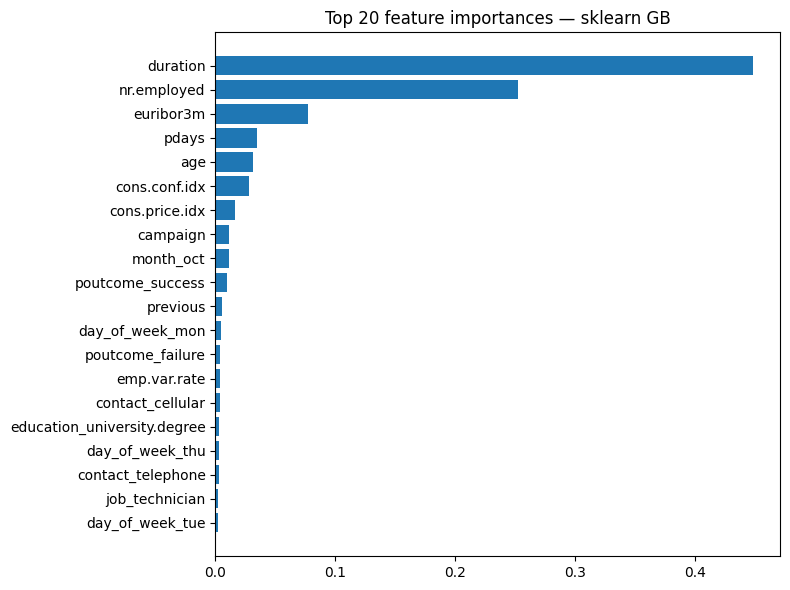

In [6]:
# Extract feature names after preprocessing
feature_names_num = num_cols
# for onehot, get names from the OneHotEncoder
ohe = gb_pipeline.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
ohe_names = list(ohe.get_feature_names_out(cat_cols))
feature_names = feature_names_num + ohe_names

import numpy as np
import matplotlib.pyplot as plt

importances = best_gb.named_steps['gradientboostingclassifier'].feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Top 20 feature importances — sklearn GB")
plt.tight_layout()
plt.show()

## Section 3 — XGBoost (`xgboost.XGBClassifier`)

XGBoost uses a second-order Taylor expansion (gradient and hessian) for the loss at each boosting iteration. The per-step objective minimized is approximated as:

$$\mathcal{L}^{(t)} \approx \sum_i \left[g_i f_t(x_i) + \tfrac{1}{2} h_i f_t(x_i)^2\right] + \Omega(f_t)$$

**Documentation:**
- [XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)
- [XGBRegressor](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor)

**Main hyperparameters:** `n_estimators`, `learning_rate` (eta), `max_depth`, `min_child_weight`, `gamma`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`.

1. **`n_estimators`**  
   - The number of boosting rounds (trees) to fit.  
   - More trees can improve performance but increase training time and risk overfitting.  
   - Often tuned together with `learning_rate`.

2. **`learning_rate` (`eta`)**  
   - Step size shrinkage applied after each boosting step to prevent overfitting.  
   - Lower values make the model more robust but require more trees (`n_estimators`).  
   - Typical range: `0.01`–`0.3`.

3. **`max_depth`**  
   - Maximum depth of a tree.  
   - Controls model complexity — deeper trees can capture more patterns but may overfit.  
   - Typical range: `3`–`10`.

4. **`min_child_weight`**  
   - Minimum sum of instance weights (Hessian) in a child node.  
   - Higher values make the algorithm more conservative (prevent overfitting).  
   - Useful for controlling tree splitting when dataset has high variance.

5. **`gamma`** (`min_split_loss`)  
   - Minimum loss reduction required to make a further partition on a leaf node.  
   - Larger values make the algorithm more conservative.  
   - Acts as a regularization parameter for tree growth.

6. **`subsample`**  
   - Fraction of the training data randomly sampled for growing each tree.  
   - Helps prevent overfitting.  
   - Typical range: `0.5`–`1.0`.

7. **`colsample_bytree`**  
   - Fraction of features (columns) randomly sampled for each tree.  
   - Helps reduce correlation between trees and overfitting.  
   - Typical range: `0.5`–`1.0`.

8. **`reg_alpha`** (L1 regularization term on weights)  
   - Increases sparsity of weights (drives some leaf values to zero).  
   - Can help in feature selection.

9. **`reg_lambda`** (L2 regularization term on weights)  
   - Penalizes large leaf weights.  
   - Helps reduce model complexity and overfitting.

xgboost all hyperparameters: https://xgboost.readthedocs.io/en/stable/parameter.html

In [7]:
# Train XGBoost (needs xgboost installed)
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Prepare data with ordinal encoding (trees don't need one-hot)
X_train_ord = ordinal_transformer.fit_transform(X_train)
X_test_ord = ordinal_transformer.transform(X_test)

xgb = XGBClassifier(eval_metric='auc', n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
xgb.fit(X_train_ord, y_train)
p_xgb = xgb.predict_proba(X_test_ord)[:,1]
print("XGBoost Test AUC:", roc_auc_score(y_test, p_xgb))

XGBoost Test AUC: 0.9550260330675976


### Hyperparameter tuning (RandomizedSearchCV)

This section runs `RandomizedSearchCV` for XGBoost.


In [8]:
# Randomized search for XGBoost
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

xgb_param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 8),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.5, 2)
}

xgb_clf = XGBClassifier(eval_metric='auc', random_state=42)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rs_xgb = RandomizedSearchCV(xgb_clf, param_distributions=xgb_param_dist, n_iter=25, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1, random_state=42)
rs_xgb.fit(X_train_ord, y_train)
print("Best XGB params:", rs_xgb.best_params_)
print("Best XGB CV AUC:", rs_xgb.best_score_)

best_xgb = rs_xgb.best_estimator_
p_xgb_best = best_xgb.predict_proba(X_test_ord)[:,1]
print("Tuned XGBoost Test AUC:", roc_auc_score(y_test, p_xgb_best))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best XGB params: {'colsample_bytree': np.float64(0.8010716092915446), 'learning_rate': np.float64(0.02029575024999787), 'max_depth': 7, 'n_estimators': 323, 'reg_alpha': np.float64(0.9082658859666537), 'reg_lambda': np.float64(0.9791237813339448), 'subsample': np.float64(0.6579579488364892)}
Best XGB CV AUC: 0.9483357284798325
Tuned XGBoost Test AUC: 0.956518733194962


### Feature importance (XGBoost)

XGBoost provides `feature_importances_` (based on gain, weight, cover) and `plot_importance` utilities. 

- **Weight (or Frequency):** This metric counts the number of times a feature is used to split the data across all trees in the model. Features with higher weight are used more frequently for splitting.

- **Gain:** This is the most common and often preferred metric. It represents the average gain (reduction in impurity) achieved by splits involving a particular feature across all trees. A higher gain indicates a more significant contribution to reducing the model's error.

- **Cover:** This metric reflects the average coverage or number of samples affected by splits involving a particular feature. It essentially measures the relative number of observations for which a feature is responsible in splits.


We'll use `feature_importances_` (gain-based if `importance_type='gain'`).


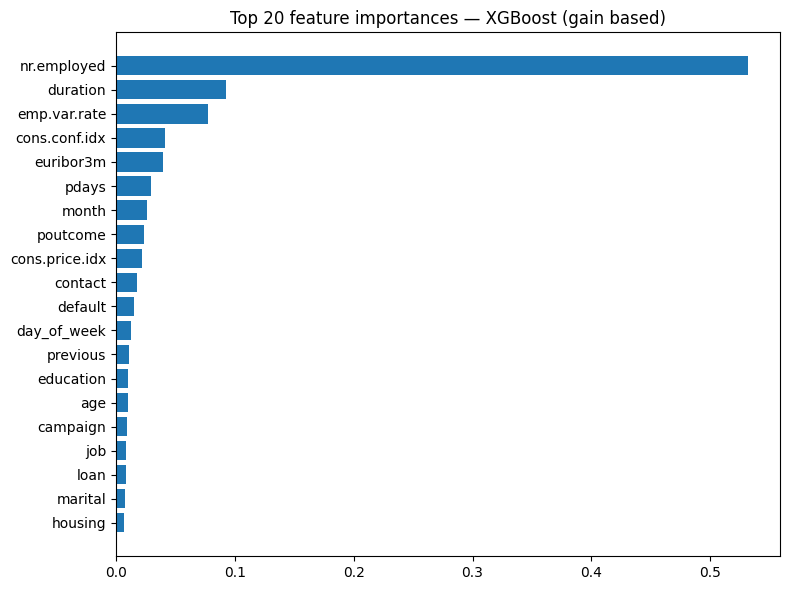

In [9]:
# Get feature names used for XGBoost (ordinal mapping produced numeric array)
# For ordinal_transformer, feature order is num_cols then cat_cols
xgb_feature_names = num_cols + cat_cols
import matplotlib.pyplot as plt
import numpy as np

importances = best_xgb.feature_importances_   # by default importance type is 'gain'
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [xgb_feature_names[i] for i in indices])
plt.title("Top 20 feature importances — XGBoost (gain based)")
plt.tight_layout()
plt.show()

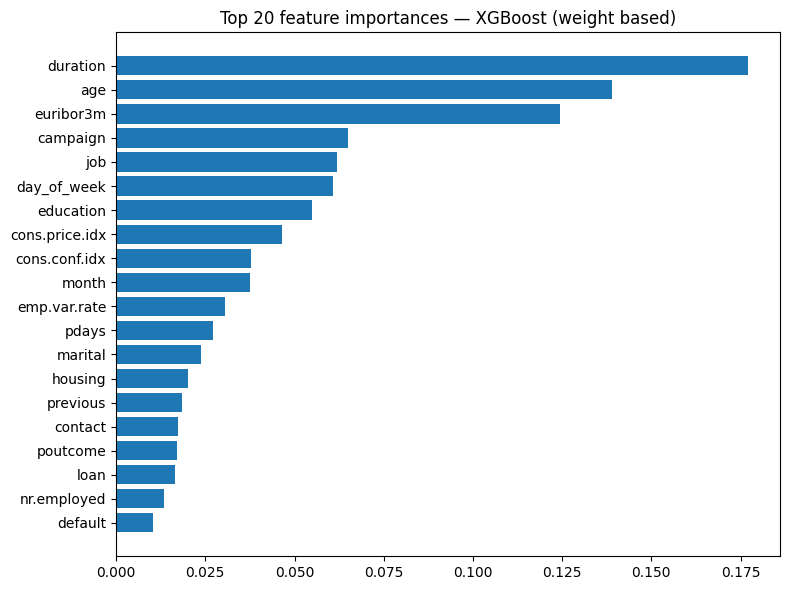

In [10]:
importances = np.array(list(best_xgb.get_booster().get_score(importance_type='weight').values())) 
importances = importances / importances.sum()
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [xgb_feature_names[i] for i in indices])
plt.title("Top 20 feature importances — XGBoost (weight based)")
plt.tight_layout()
plt.show()

### Optional: Bayesian optimization with Optuna (XGBoost)

This subsection uses **Optuna** to find a high-performing set of hyperparameters. It executes multiple trials — be prepared to wait depending on `n_trials`.


In [11]:
# Optuna for XGBoost (ensure optuna is installed)
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0)
    }
    clf = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42, **param)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train_ord, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)
print("Best optuna params:", study.best_params)
# Train final with best params
optuna_xgb = XGBClassifier(use_label_encoder=False, eval_metric='auc', random_state=42, **study.best_params)
optuna_xgb.fit(X_train_ord, y_train)
print("Optuna XGBoost Test AUC:", roc_auc_score(y_test, optuna_xgb.predict_proba(X_test_ord)[:,1]))

c:\Users\Sourav Karmakar\Desktop\Work\LogicMojo\logicmojo-data-science-april-2025\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-08-23 22:16:46,719] A new study created in memory with name: no-name-18e62474-e2b6-470d-80cd-0cf166c4dfb9
  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se

[I 2025-08-23 22:16:48,232] Trial 0 finished with value: 0.9462038306026578 and parameters: {'n_estimators': 341, 'learning_rate': 0.07427845605110542, 'max_depth': 5, 'subsample': 0.648936453679377, 'colsample_bytree': 0.6005429228119396, 'reg_alpha': 0.00795547533145857, 'reg_lambda': 0.15771020164634897}. Best is trial 0 with value: 0.9462038306026578.


Best trial: 1. Best value: 0.946284:   7%|▋         | 2/30 [00:02<00:35,  1.26s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0

[I 2025-08-23 22:16:49,318] Trial 1 finished with value: 0.9462842571800717 and parameters: {'n_estimators': 198, 'learning_rate': 0.07481301995852074, 'max_depth': 7, 'subsample': 0.8656921864070308, 'colsample_bytree': 0.8773560833540053, 'reg_alpha': 0.09876295903975708, 'reg_lambda': 0.87784970070305}. Best is trial 1 with value: 0.9462842571800717.


Best trial: 2. Best value: 0.94734:  10%|█         | 3/30 [00:03<00:35,  1.30s/it] C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0

[I 2025-08-23 22:16:50,663] Trial 2 finished with value: 0.9473397282594762 and parameters: {'n_estimators': 248, 'learning_rate': 0.04213596578550373, 'max_depth': 7, 'subsample': 0.8878424981095814, 'colsample_bytree': 0.6286055456916759, 'reg_alpha': 0.0020237371668782407, 'reg_lambda': 0.004068569282548015}. Best is trial 2 with value: 0.9473397282594762.


Best trial: 2. Best value: 0.94734:  13%|█▎        | 4/30 [00:06<00:42,  1.65s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

[I 2025-08-23 22:16:52,846] Trial 3 finished with value: 0.9427225542998721 and parameters: {'n_estimators': 447, 'learning_rate': 0.11043430320897453, 'max_depth': 6, 'subsample': 0.9497381109940837, 'colsample_bytree': 0.841818376920415, 'reg_alpha': 0.14352145150435397, 'reg_lambda': 0.042160141413627554}. Best is trial 2 with value: 0.9473397282594762.


Best trial: 2. Best value: 0.94734:  17%|█▋        | 5/30 [00:08<00:48,  1.95s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

[I 2025-08-23 22:16:55,341] Trial 4 finished with value: 0.9467588902452403 and parameters: {'n_estimators': 416, 'learning_rate': 0.05407383533773661, 'max_depth': 8, 'subsample': 0.8978801936730942, 'colsample_bytree': 0.6443236033868511, 'reg_alpha': 3.9590436887457185, 'reg_lambda': 0.017502049755639213}. Best is trial 2 with value: 0.9473397282594762.


Best trial: 5. Best value: 0.948133:  20%|██        | 6/30 [00:09<00:42,  1.75s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0

[I 2025-08-23 22:16:56,698] Trial 5 finished with value: 0.9481332933448474 and parameters: {'n_estimators': 213, 'learning_rate': 0.05156885198179489, 'max_depth': 7, 'subsample': 0.9281313085072357, 'colsample_bytree': 0.9922582857809059, 'reg_alpha': 0.7003588955896938, 'reg_lambda': 5.04050838310003}. Best is trial 5 with value: 0.9481332933448474.


Best trial: 5. Best value: 0.948133:  23%|██▎       | 7/30 [00:11<00:35,  1.56s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0

[I 2025-08-23 22:16:57,857] Trial 6 finished with value: 0.9471876277193635 and parameters: {'n_estimators': 298, 'learning_rate': 0.08949995424351039, 'max_depth': 4, 'subsample': 0.9335663816543909, 'colsample_bytree': 0.6933907312371341, 'reg_alpha': 0.07393762495538897, 'reg_lambda': 0.07133669208541597}. Best is trial 5 with value: 0.9481332933448474.


Best trial: 7. Best value: 0.948282:  27%|██▋       | 8/30 [00:13<00:38,  1.73s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0

[I 2025-08-23 22:16:59,956] Trial 7 finished with value: 0.9482820836185843 and parameters: {'n_estimators': 491, 'learning_rate': 0.020029587910598338, 'max_depth': 6, 'subsample': 0.9865618604271306, 'colsample_bytree': 0.6297489009629628, 'reg_alpha': 5.907147948343728, 'reg_lambda': 0.024060965133994746}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  30%|███       | 9/30 [00:14<00:32,  1.56s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0

[I 2025-08-23 22:17:01,148] Trial 8 finished with value: 0.947253365467119 and parameters: {'n_estimators': 217, 'learning_rate': 0.024383411442612177, 'max_depth': 5, 'subsample': 0.9023487047113858, 'colsample_bytree': 0.7860729758233996, 'reg_alpha': 0.06331519775660148, 'reg_lambda': 0.5225040311650877}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  33%|███▎      | 10/30 [00:15<00:27,  1.35s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:02,028] Trial 9 finished with value: 0.9479908661178545 and parameters: {'n_estimators': 151, 'learning_rate': 0.05774561041989313, 'max_depth': 7, 'subsample': 0.7442350555537478, 'colsample_bytree': 0.6798836404479027, 'reg_alpha': 4.514562010264577, 'reg_lambda': 2.5906829573897574}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  37%|███▋      | 11/30 [00:17<00:29,  1.53s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:03,960] Trial 10 finished with value: 0.9413100376653927 and parameters: {'n_estimators': 488, 'learning_rate': 0.010989819283105629, 'max_depth': 3, 'subsample': 0.7825858797919053, 'colsample_bytree': 0.7464955394375506, 'reg_alpha': 9.811565151012394, 'reg_lambda': 0.0017826865196014893}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  40%|████      | 12/30 [00:17<00:22,  1.27s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:04,629] Trial 11 finished with value: 0.9455255024988357 and parameters: {'n_estimators': 103, 'learning_rate': 0.02511440561720521, 'max_depth': 6, 'subsample': 0.9960264233410097, 'colsample_bytree': 0.9904772681394691, 'reg_alpha': 0.772347664307181, 'reg_lambda': 7.94109028143826}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  43%|████▎     | 13/30 [00:19<00:25,  1.49s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:06,645] Trial 12 finished with value: 0.946732637984538 and parameters: {'n_estimators': 353, 'learning_rate': 0.02781488151280564, 'max_depth': 8, 'subsample': 0.989855828954915, 'colsample_bytree': 0.9949178171374242, 'reg_alpha': 0.7342664016067664, 'reg_lambda': 0.009756628042642145}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  47%|████▋     | 14/30 [00:21<00:23,  1.49s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:08,124] Trial 13 finished with value: 0.9477470811845605 and parameters: {'n_estimators': 302, 'learning_rate': 0.010917523305903851, 'max_depth': 6, 'subsample': 0.6955830391554819, 'colsample_bytree': 0.8767258275913336, 'reg_alpha': 0.9594445709931737, 'reg_lambda': 0.23373396197164178}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  50%|█████     | 15/30 [00:23<00:25,  1.69s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:10,291] Trial 14 finished with value: 0.9422894953087071 and parameters: {'n_estimators': 387, 'learning_rate': 0.16057019299714403, 'max_depth': 7, 'subsample': 0.8359005483857055, 'colsample_bytree': 0.9297471454420632, 'reg_alpha': 1.993682549426377, 'reg_lambda': 7.776633099914457}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  53%|█████▎    | 16/30 [00:25<00:24,  1.76s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:12,219] Trial 15 finished with value: 0.9479070313739945 and parameters: {'n_estimators': 500, 'learning_rate': 0.018153489625086353, 'max_depth': 5, 'subsample': 0.9544198534109882, 'colsample_bytree': 0.7638788989197361, 'reg_alpha': 0.37587811243483593, 'reg_lambda': 0.024662848957439747}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  57%|█████▋    | 17/30 [00:26<00:21,  1.67s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:13,678] Trial 16 finished with value: 0.9482102713540291 and parameters: {'n_estimators': 275, 'learning_rate': 0.039132178088618116, 'max_depth': 8, 'subsample': 0.8275195360915951, 'colsample_bytree': 0.7216943982990649, 'reg_alpha': 9.65293275259012, 'reg_lambda': 0.0011617304720122888}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  60%|██████    | 18/30 [00:28<00:19,  1.64s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:15,235] Trial 17 finished with value: 0.9467194155677308 and parameters: {'n_estimators': 293, 'learning_rate': 0.016162564081721325, 'max_depth': 8, 'subsample': 0.6086918474302634, 'colsample_bytree': 0.7230960834951474, 'reg_alpha': 7.834291478324283, 'reg_lambda': 0.0014023655547097495}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  63%|██████▎   | 19/30 [00:29<00:16,  1.47s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:16,313] Trial 18 finished with value: 0.9468638924985848 and parameters: {'n_estimators': 263, 'learning_rate': 0.03545087615672042, 'max_depth': 4, 'subsample': 0.8072390611136774, 'colsample_bytree': 0.6794074284627579, 'reg_alpha': 0.014928259654076235, 'reg_lambda': 0.005598994351122535}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  67%|██████▋   | 20/30 [00:31<00:14,  1.46s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:17,767] Trial 19 finished with value: 0.9457332925007917 and parameters: {'n_estimators': 367, 'learning_rate': 0.016764875464704048, 'max_depth': 4, 'subsample': 0.7404803269035392, 'colsample_bytree': 0.7168283014414147, 'reg_alpha': 2.746342519122984, 'reg_lambda': 0.0036272168942705863}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  70%|███████   | 21/30 [00:33<00:15,  1.72s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:20,077] Trial 20 finished with value: 0.9463095777541554 and parameters: {'n_estimators': 424, 'learning_rate': 0.035602432706475104, 'max_depth': 8, 'subsample': 0.8270238190788303, 'colsample_bytree': 0.6461794333860246, 'reg_alpha': 0.22295713627677896, 'reg_lambda': 0.0010134723586485176}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 7. Best value: 0.948282:  73%|███████▎  | 22/30 [00:34<00:12,  1.55s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

[I 2025-08-23 22:17:21,230] Trial 21 finished with value: 0.9481256569048392 and parameters: {'n_estimators': 182, 'learning_rate': 0.051600013485165006, 'max_depth': 7, 'subsample': 0.942310963794804, 'colsample_bytree': 0.8207222245882495, 'reg_alpha': 1.6703981170485367, 'reg_lambda': 2.122036733808107}. Best is trial 7 with value: 0.9482820836185843.


Best trial: 22. Best value: 0.948425:  77%|███████▋  | 23/30 [00:35<00:10,  1.46s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

[I 2025-08-23 22:17:22,490] Trial 22 finished with value: 0.9484246451943567 and parameters: {'n_estimators': 241, 'learning_rate': 0.03640813352419771, 'max_depth': 6, 'subsample': 0.869547368497655, 'colsample_bytree': 0.9410599200318049, 'reg_alpha': 5.445107762319688, 'reg_lambda': 0.40102273362844615}. Best is trial 22 with value: 0.9484246451943567.


Best trial: 22. Best value: 0.948425:  80%|████████  | 24/30 [00:36<00:08,  1.37s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

[I 2025-08-23 22:17:23,635] Trial 23 finished with value: 0.9473296478129384 and parameters: {'n_estimators': 236, 'learning_rate': 0.02761293318011915, 'max_depth': 6, 'subsample': 0.8509108091967165, 'colsample_bytree': 0.9400021946707771, 'reg_alpha': 8.749928515140942, 'reg_lambda': 0.4393831270466072}. Best is trial 22 with value: 0.9484246451943567.


Best trial: 22. Best value: 0.948425:  83%|████████▎ | 25/30 [00:38<00:06,  1.37s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

[I 2025-08-23 22:17:25,017] Trial 24 finished with value: 0.9473055579411221 and parameters: {'n_estimators': 323, 'learning_rate': 0.020320154882984193, 'max_depth': 5, 'subsample': 0.7776176794069386, 'colsample_bytree': 0.7817830457729666, 'reg_alpha': 4.534092290143738, 'reg_lambda': 0.0750536527401575}. Best is trial 22 with value: 0.9484246451943567.


Best trial: 22. Best value: 0.948425:  87%|████████▋ | 26/30 [00:39<00:05,  1.37s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

[I 2025-08-23 22:17:26,372] Trial 25 finished with value: 0.9483820037449284 and parameters: {'n_estimators': 271, 'learning_rate': 0.03611682841782935, 'max_depth': 6, 'subsample': 0.8658845097184514, 'colsample_bytree': 0.6008281921647515, 'reg_alpha': 1.7451477874793995, 'reg_lambda': 0.20311427345643157}. Best is trial 22 with value: 0.9484246451943567.


Best trial: 22. Best value: 0.948425:  90%|█████████ | 27/30 [00:40<00:03,  1.24s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

[I 2025-08-23 22:17:27,303] Trial 26 finished with value: 0.9478266471749048 and parameters: {'n_estimators': 159, 'learning_rate': 0.033484967532121504, 'max_depth': 6, 'subsample': 0.8749832373820897, 'colsample_bytree': 0.6113376695551754, 'reg_alpha': 1.6556387282289355, 'reg_lambda': 0.17758097409216483}. Best is trial 22 with value: 0.9484246451943567.


Best trial: 22. Best value: 0.948425:  93%|█████████▎| 28/30 [00:42<00:03,  1.50s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

[I 2025-08-23 22:17:29,421] Trial 27 finished with value: 0.9481311724186011 and parameters: {'n_estimators': 465, 'learning_rate': 0.014671680943770481, 'max_depth': 6, 'subsample': 0.9659024818725566, 'colsample_bytree': 0.9366198336898589, 'reg_alpha': 0.02960449735869511, 'reg_lambda': 1.13599821616742}. Best is trial 22 with value: 0.9484246451943567.


Best trial: 22. Best value: 0.948425:  97%|█████████▋| 29/30 [00:44<00:01,  1.54s/it]C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
C:\Users\Sourav Karmakar\AppData\Local\Temp\ipykernel_27700\2164613506.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

[I 2025-08-23 22:17:31,066] Trial 28 finished with value: 0.9479508110862254 and parameters: {'n_estimators': 387, 'learning_rate': 0.02111397725831151, 'max_depth': 5, 'subsample': 0.9101244417618, 'colsample_bytree': 0.6675483892031701, 'reg_alpha': 0.3741128051455487, 'reg_lambda': 0.34458415837336664}. Best is trial 22 with value: 0.9484246451943567.


Best trial: 22. Best value: 0.948425: 100%|██████████| 30/30 [00:45<00:00,  1.53s/it]
c:\Users\Sourav Karmakar\Desktop\Work\LogicMojo\logicmojo-data-science-april-2025\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:17:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[I 2025-08-23 22:17:32,581] Trial 29 finished with value: 0.9473459165221545 and parameters: {'n_estimators': 333, 'learning_rate': 0.013319700443550686, 'max_depth': 5, 'subsample': 0.7074928290352691, 'colsample_bytree': 0.6014185475846915, 'reg_alpha': 0.0030445127494733654, 'reg_lambda': 0.12562453739065801}. Best is trial 22 with value: 0.9484246451943567.
Best optuna params: {'n_estimators': 241, 'learning_rate': 0.03640813352419771, 'max_depth': 6, 'subsample': 0.869547368497655, 'colsample_bytree': 0.9410599200318049, 'reg_alpha': 5.445107762319688, 'reg_lambda': 0.40102273362844615}
Optuna XGBoost Test AUC: 0.9561056830510873


## Section 4 — LightGBM (`lightgbm.LGBMClassifier`)

LightGBM is optimized for performance on large datasets using histogram-based algorithms and techniques like GOSS and EFB.

**LightGBM Documentation:**
- [LightGBM Classifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)
- [LightGBM Regressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html)

**Main hyperparameters:** `n_estimators`, `learning_rate`, `num_leaves`, `max_depth`, `min_data_in_leaf`, `subsample`, `colsample_bytree`, `reg_alpha`, `reg_lambda`.

**LightGBM all hyperparameter:** https://lightgbm.readthedocs.io/en/latest/Parameters.html


In [14]:
# Train LightGBM (requires lightgbm installed)
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42)
# Use ordinal encoded arrays
lgb_clf.fit(X_train_ord, y_train, eval_set=[(X_test_ord, y_test)], eval_metric='auc')
print("LightGBM Test AUC:", roc_auc_score(y_test, lgb_clf.predict_proba(X_test_ord)[:,1]))

[LightGBM] [Info] Number of positive: 3712, number of negative: 29238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 32950, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112656 -> initscore=-2.063898
[LightGBM] [Info] Start training from score -2.063898
LightGBM Test AUC: 0.9536957816406435


c:\Users\Sourav Karmakar\Desktop\Work\LogicMojo\logicmojo-data-science-april-2025\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Hyperparameter tuning (RandomizedSearchCV)


In [15]:
# Randomized search for LightGBM
from scipy.stats import randint, uniform

lgb_param_dist = {
    'n_estimators': randint(100, 800),
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 150),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

lgb_model = lgb.LGBMClassifier(random_state=42)
rs_lgb = RandomizedSearchCV(lgb_model, param_distributions=lgb_param_dist, n_iter=25, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1, random_state=42)
rs_lgb.fit(X_train_ord, y_train)
print("Best LGB params:", rs_lgb.best_params_)
print("Best LGB CV AUC:", rs_lgb.best_score_)

best_lgb = rs_lgb.best_estimator_
print("Tuned LightGBM Test AUC:", roc_auc_score(y_test, best_lgb.predict_proba(X_test_ord)[:,1]))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\Sourav Karmakar\Desktop\Work\LogicMojo\logicmojo-data-science-april-2025\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3712, number of negative: 29238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 726
[LightGBM] [Info] Number of data points in the train set: 32950, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112656 -> initscore=-2.063898
[LightGBM] [Info] Start training from score -2.063898
Best LGB params: {'colsample_bytree': np.float64(0.9754210836063001), 'learning_rate': np.float64(0.010155753168202867), 'n_estimators': 376, 'num_leaves': 77, 'subsample': np.float64(0.8099025726528951)}
Best LGB CV AUC: 0.9487137446275623
Tuned LightGBM Test AUC: 0.9554385672673239


c:\Users\Sourav Karmakar\Desktop\Work\LogicMojo\logicmojo-data-science-april-2025\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Feature importance (LightGBM)


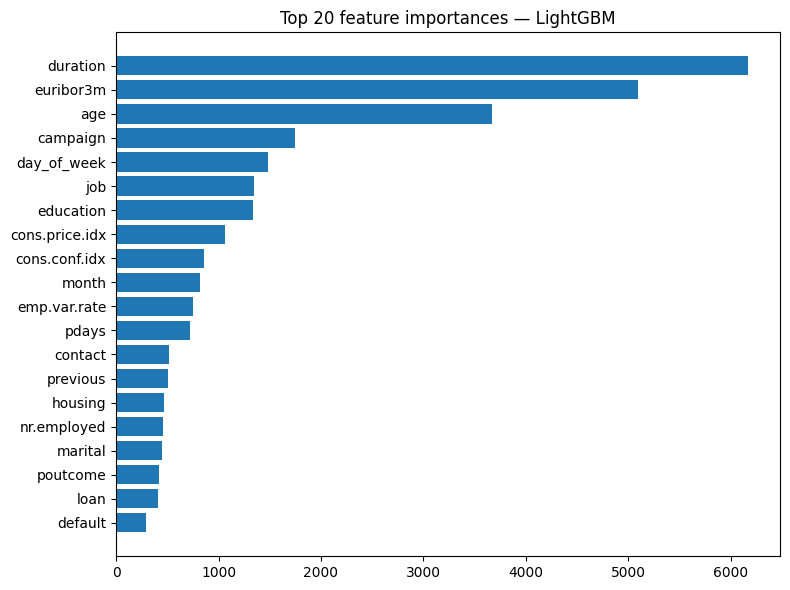

In [16]:
# Feature importances from LightGBM
import numpy as np
import matplotlib.pyplot as plt

fi = best_lgb.feature_importances_
indices = np.argsort(fi)[-20:]
feature_names = num_cols + cat_cols

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), fi[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Top 20 feature importances — LightGBM")
plt.tight_layout()
plt.show()

## Section 5 — CatBoost (`catboost.CatBoostClassifier`)

CatBoost handles categorical features natively and uses ordered boosting to reduce target leakage. Provide categorical feature names/indices to the model.

**Documentation:**

- [CatBoost Classifier](https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier)
- [CatBoost Regressor](https://catboost.ai/docs/en/concepts/python-reference_catboostregressor)

**Main hyperparameters:** `iterations`, `learning_rate`, `depth`, `l2_leaf_reg`, `bagging_temperature`, `border_count`.

- `iterations`: Number of boosting rounds (trees) to build. More iterations can improve accuracy but risk overfitting.

- `learning_rate`: Step size for updating trees. Smaller values improve generalization but need more iterations.

- `depth`: Maximum depth of each tree, controlling model complexity. Higher depth captures interactions but risks overfitting.

- `l2_leaf_reg`: L2 regularization coefficient for leaf values. Helps prevent overfitting by penalizing large weights.

- `bagging_temperature`: Controls randomness in sampling. Higher values → more uniform sampling; lower values → greedier sampling of best points.

- `border_count`: Number of splits (bins) used for numeric feature discretization. Larger values give finer splits but increase computation.



In [17]:
# Train CatBoost (requires catboost installed)
from catboost import CatBoostClassifier

# Prepare data: pass raw DataFrame and list of categorical feature names
cat_features = cat_cols  # these are column NAMES in the original DataFrame
cb = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=50, random_seed=42)
cb.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), early_stopping_rounds=50)
print("CatBoost Test AUC:", roc_auc_score(y_test, cb.predict_proba(X_test)[:,1]))

0:	learn: 0.6048045	test: 0.6040668	best: 0.6040668 (0)	total: 251ms	remaining: 2m 5s
50:	learn: 0.1833090	test: 0.1766629	best: 0.1766629 (50)	total: 3.81s	remaining: 33.5s
100:	learn: 0.1742793	test: 0.1686976	best: 0.1686976 (100)	total: 7.3s	remaining: 28.8s
150:	learn: 0.1707654	test: 0.1668580	best: 0.1668580 (150)	total: 10.6s	remaining: 24.4s
200:	learn: 0.1679431	test: 0.1654560	best: 0.1654560 (200)	total: 14s	remaining: 20.8s
250:	learn: 0.1649700	test: 0.1643982	best: 0.1643859 (248)	total: 17.6s	remaining: 17.5s
300:	learn: 0.1623980	test: 0.1633831	best: 0.1633750 (298)	total: 21.2s	remaining: 14s
350:	learn: 0.1604206	test: 0.1628895	best: 0.1628844 (347)	total: 24.8s	remaining: 10.5s
400:	learn: 0.1583587	test: 0.1624645	best: 0.1624092 (384)	total: 28.4s	remaining: 7s
450:	learn: 0.1565964	test: 0.1623147	best: 0.1622967 (446)	total: 32s	remaining: 3.47s
499:	learn: 0.1550969	test: 0.1622820	best: 0.1621931 (480)	total: 35.5s	remaining: 0us

bestTest = 0.1621931449
bes

### Hyperparameter tuning (RandomizedSearchCV / CatBoost)


In [ ]:
# Randomized search for CatBoost (uses sklearn wrapper)
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

cb_param_dist = {
    'iterations': randint(100, 800),
    'learning_rate': uniform(0.01, 0.2),
    'depth': randint(3, 8),
    'l2_leaf_reg': uniform(1, 10)
}

cb_model = CatBoostClassifier(verbose=0, random_seed=42)
rs_cb = RandomizedSearchCV(cb_model, param_distributions=cb_param_dist, n_iter=20, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1, random_state=42)
# For CatBoost, we need to pass DataFrame and categorical feature indices to fit; RandomizedSearchCV will call fit with arrays.
# To keep it simple, we'll fit on a converted dataset with ordinal encoding (already done above)
rs_cb.fit(X_train_ord, y_train)
print("Best CatBoost params:", rs_cb.best_params_)
print("Best CatBoost CV AUC:", rs_cb.best_score_)

best_cb = rs_cb.best_estimator_
print("Tuned CatBoost Test AUC:", roc_auc_score(y_test, best_cb.predict_proba(X_test_ord)[:,1]))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best CatBoost params: {'depth': 7, 'iterations': 746, 'l2_leaf_reg': np.float64(2.705241236872915), 'learning_rate': np.float64(0.023010318597055907)}
Best CatBoost CV AUC: 0.9476975865850239
Tuned CatBoost Test AUC: 0.9564748042360488


### Feature importance (CatBoost)

CatBoost exposes `get_feature_importance` which supports several importance types (PredictionValuesChange, LossFunctionChange, ShapValues, etc.).


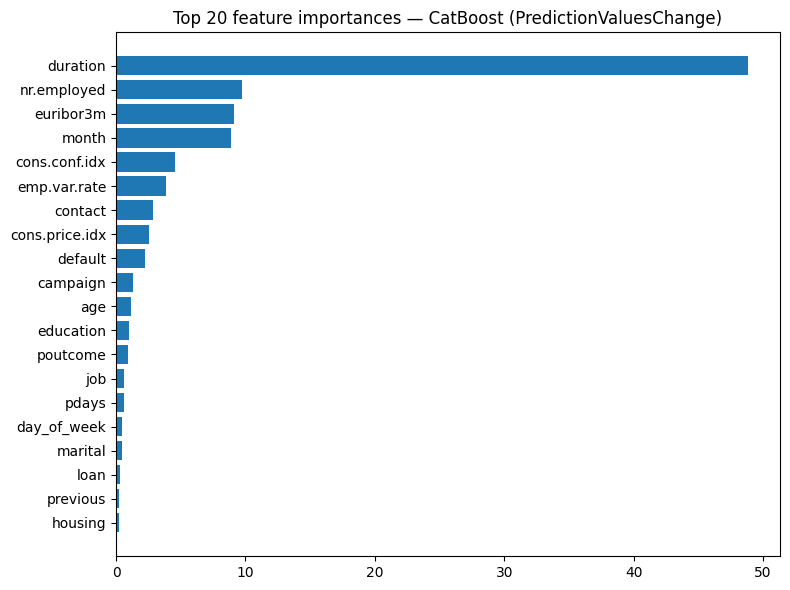

In [20]:
from catboost import Pool

# CatBoost feature importance (using PredictionValuesChange)
fi_cb = cb.get_feature_importance(type='PredictionValuesChange', data=Pool(X_train, label=y_train, cat_features=cat_features))
feature_names_all = X_train.columns.tolist()
indices = np.argsort(fi_cb)[-20:]

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), fi_cb[indices], align='center')
plt.yticks(range(len(indices)), [feature_names_all[i] for i in indices])
plt.title("Top 20 feature importances — CatBoost (PredictionValuesChange)")
plt.tight_layout()
plt.show()

## Summary & Practical tips

- All four gradient-boosting families are included with tuning and feature importance.
- Running all tuning steps will take time; adjust `n_iter` / `n_trials` for faster runs.
- Use early stopping where supported to reduce overfitting and speed up tuning.

---

Place `bank-additional-full.csv` in the same folder as this notebook and run all cells.
